In [1]:
### Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as c
import os, sys
from astropy.table import Table, vstack
from astropy import units as u
from astropy.io import ascii
from astropy.time import Time

### Get some information from the three vlbi surveys with b-smbh candidates

**GOODS-N** 
* central rms 9 uJy/beam
* \#sources targeted ~ 340 sources
* Contigious $7.5^2\cdot\pi$ arcmin squared. 
* Five separate pointings.
* One candidate bsmbh.

**COSMOS-VLBA**
* central rms ~10 uJy/beam
* \#sources targeted ~ 2865
* 4 deg squared area.
* Made of 23 pointings.
* 2 candidate bsmbhs

**SPARCS-N**
* central rms ~ 6 uJy/beam
* \# sources targeted ~ 52
* $0.5^2\cdot\pi$ area 
* One pointing
* One B-SMBH candidate

### SWEEPs estimates per year

In [2]:
if os.path.exists('evn_obs.ecsv') == False:
    import pyvo as vo
    service = vo.dal.TAPService("https://evn-vo.jive.eu/tap")
    x = np.linspace(-90,90,361)
    for i in range(360):
        if i%10 == 0:
            print(x[i])
        resultset = service.search("""SELECT *
                                    FROM evn.main WHERE s_dec BETWEEN %d AND %d"""%(x[i],x[i+1]))
        
        if i == 0:
            at = resultset.to_table()
        else:
            at = vstack([at, resultset.to_table()])
    at.write('evn_obs.ecsv', overwrite=True)
at = ascii.read('evn_obs.ecsv')

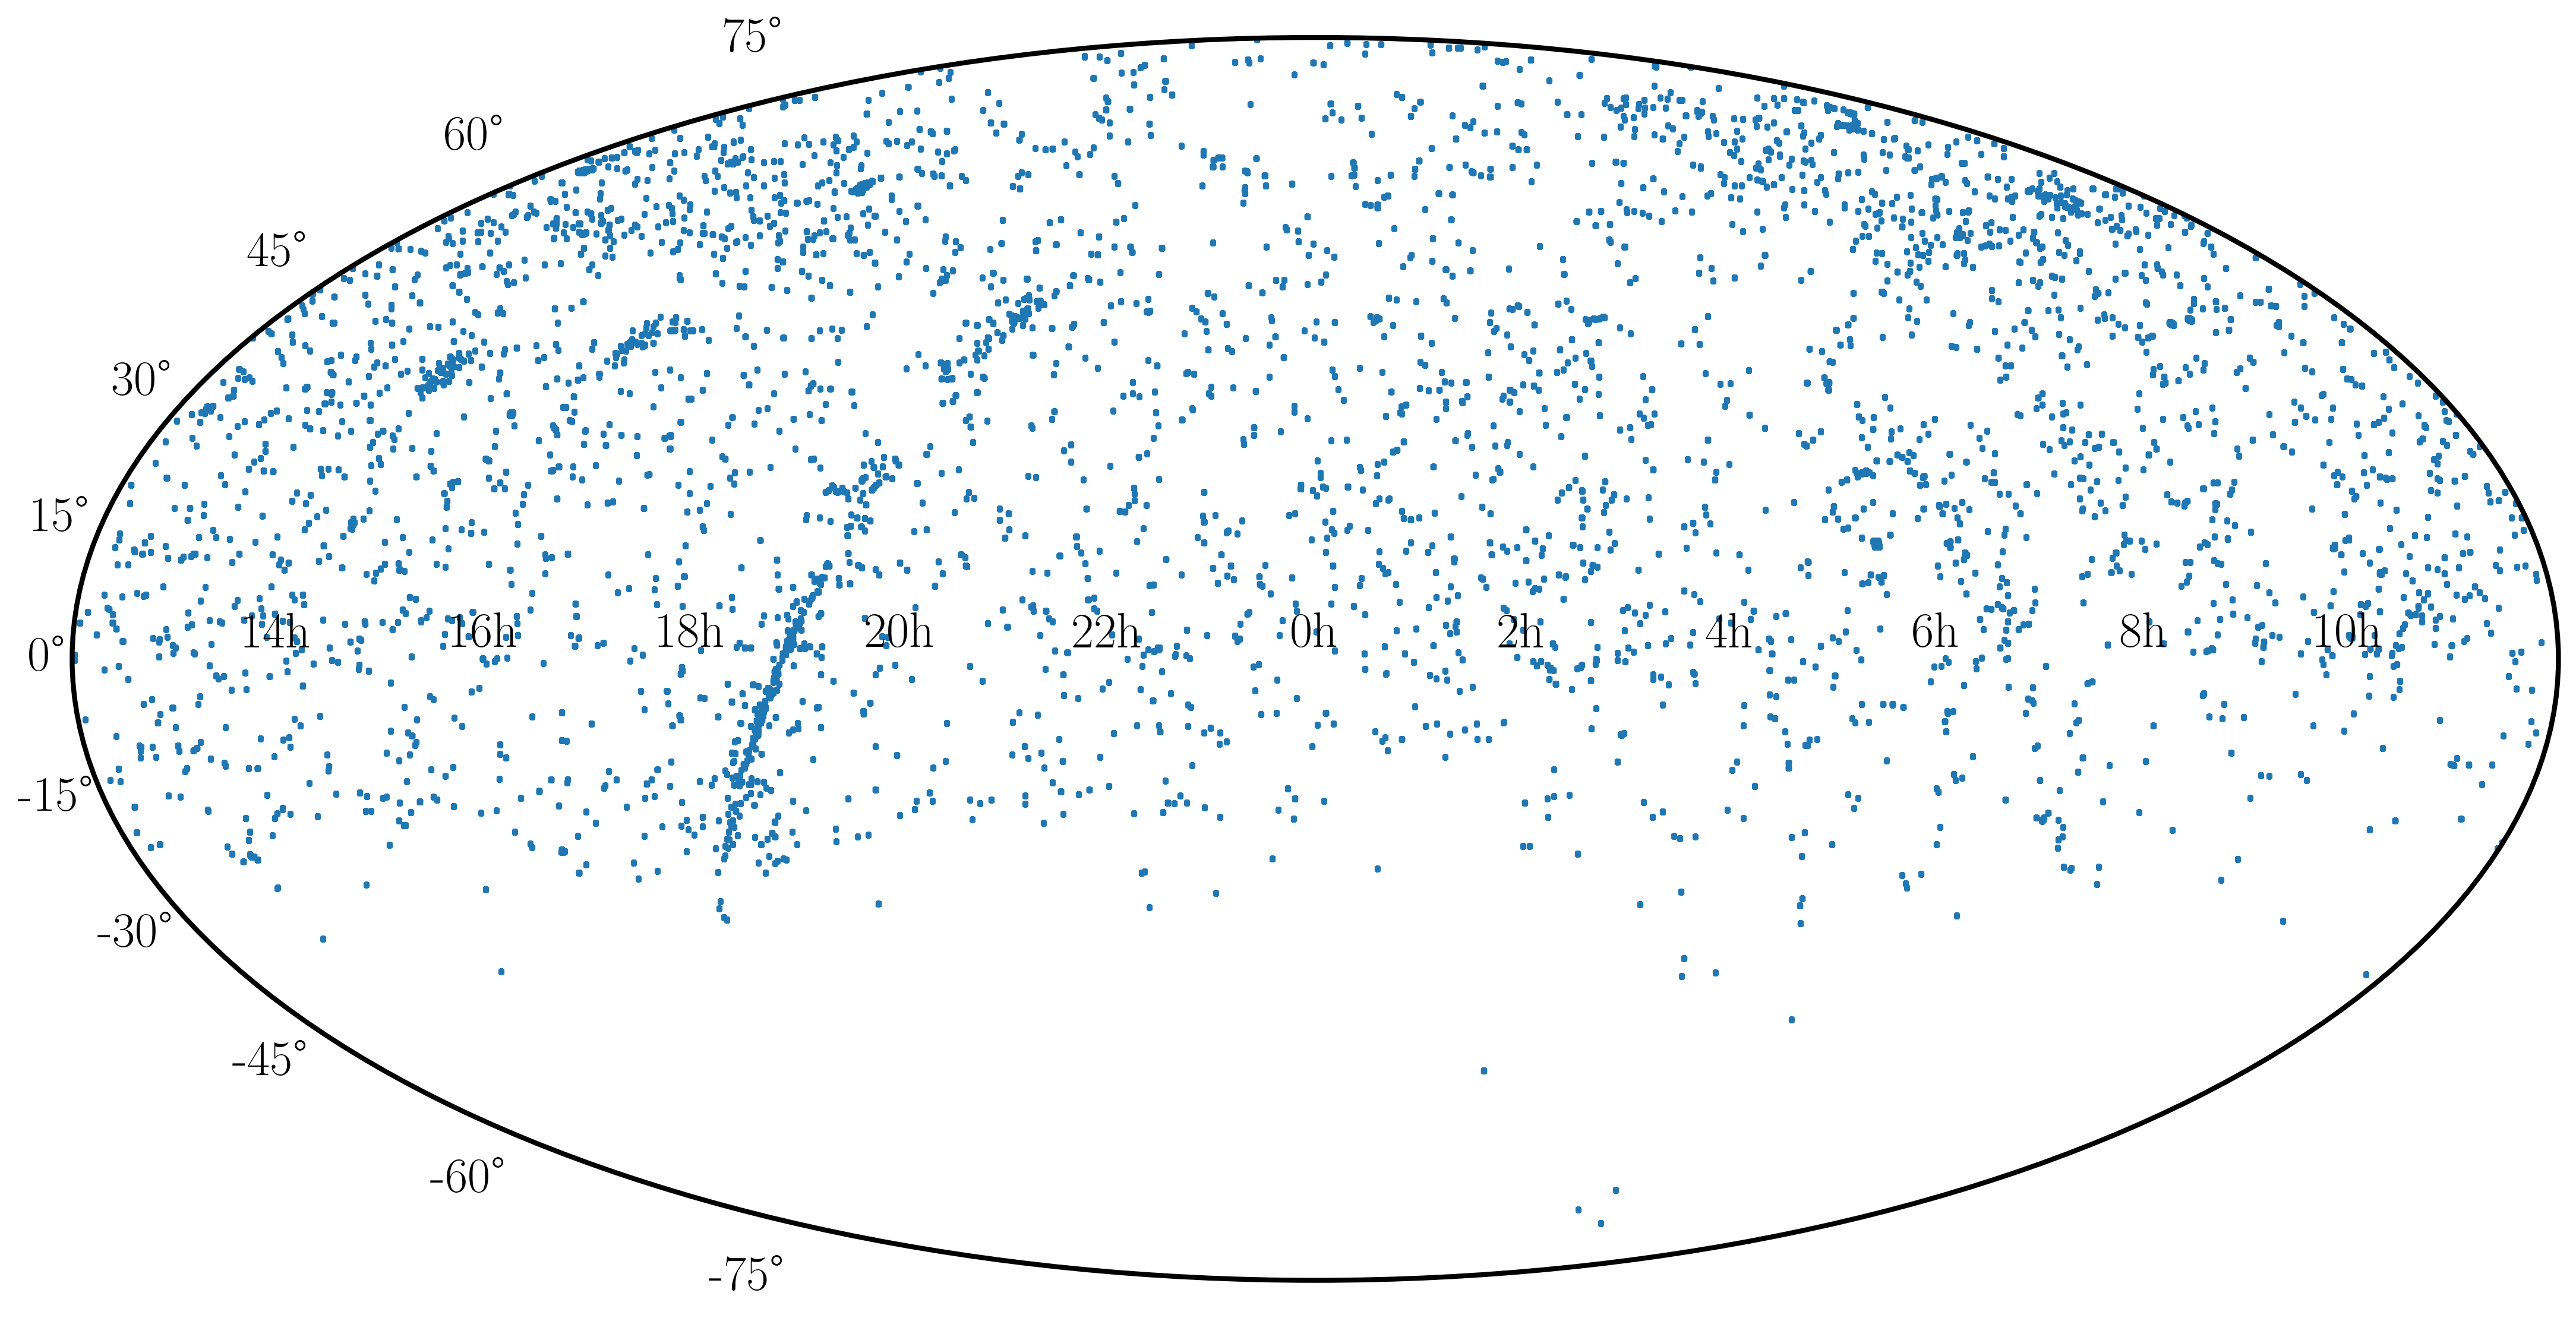

In [3]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter((at['s_ra']).to(u.radian), (at['s_dec']).to(u.radian),s=1.5)
#ax.scatter(ra, (evn_obs[1]*u.deg).to(u.radian),s=0.1)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
plt.show()

In [4]:
t = Time(at['t_max'],format='mjd')

In [10]:
yr_iso = np.arange(1998,2026,1)
yr = Time(np.char.add(np.arange(1998,2026,1).astype('str'),'-01-01T00:00:00.000')).mjd

In [15]:
n_exp = []
n_epo = []
L_exp = []
L_t = []
for i in range(len(yr)-1):
    n_epo.append(len(at['t_min'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])]))
    n_exp.append(len(np.unique(at['obs_id'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])])))
    L_exp.append(len(np.unique(at['obs_id'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])&\
                                           (at['em_min']>0.15)&(at['em_max']<0.25)])))
    t_min = np.unique(at['t_min','t_max'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])&\
                            (at['em_min']>0.15)&(at['em_max']<0.25)])['t_min']
    t_max = np.unique(at['t_min','t_max'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])&\
                            (at['em_min']>0.15)&(at['em_max']<0.25)])['t_max']
    L_t.append(np.sum(t_max-t_min))

<>:6: SyntaxWarning: invalid escape sequence '\#'
<>:6: SyntaxWarning: invalid escape sequence '\#'
/var/folders/95/2mdwxkv53dg0z1fx0__lvyxw0000gq/T/ipykernel_9270/3517064889.py:6: SyntaxWarning: invalid escape sequence '\#'
  ax.set_ylabel('\# experiments per year')


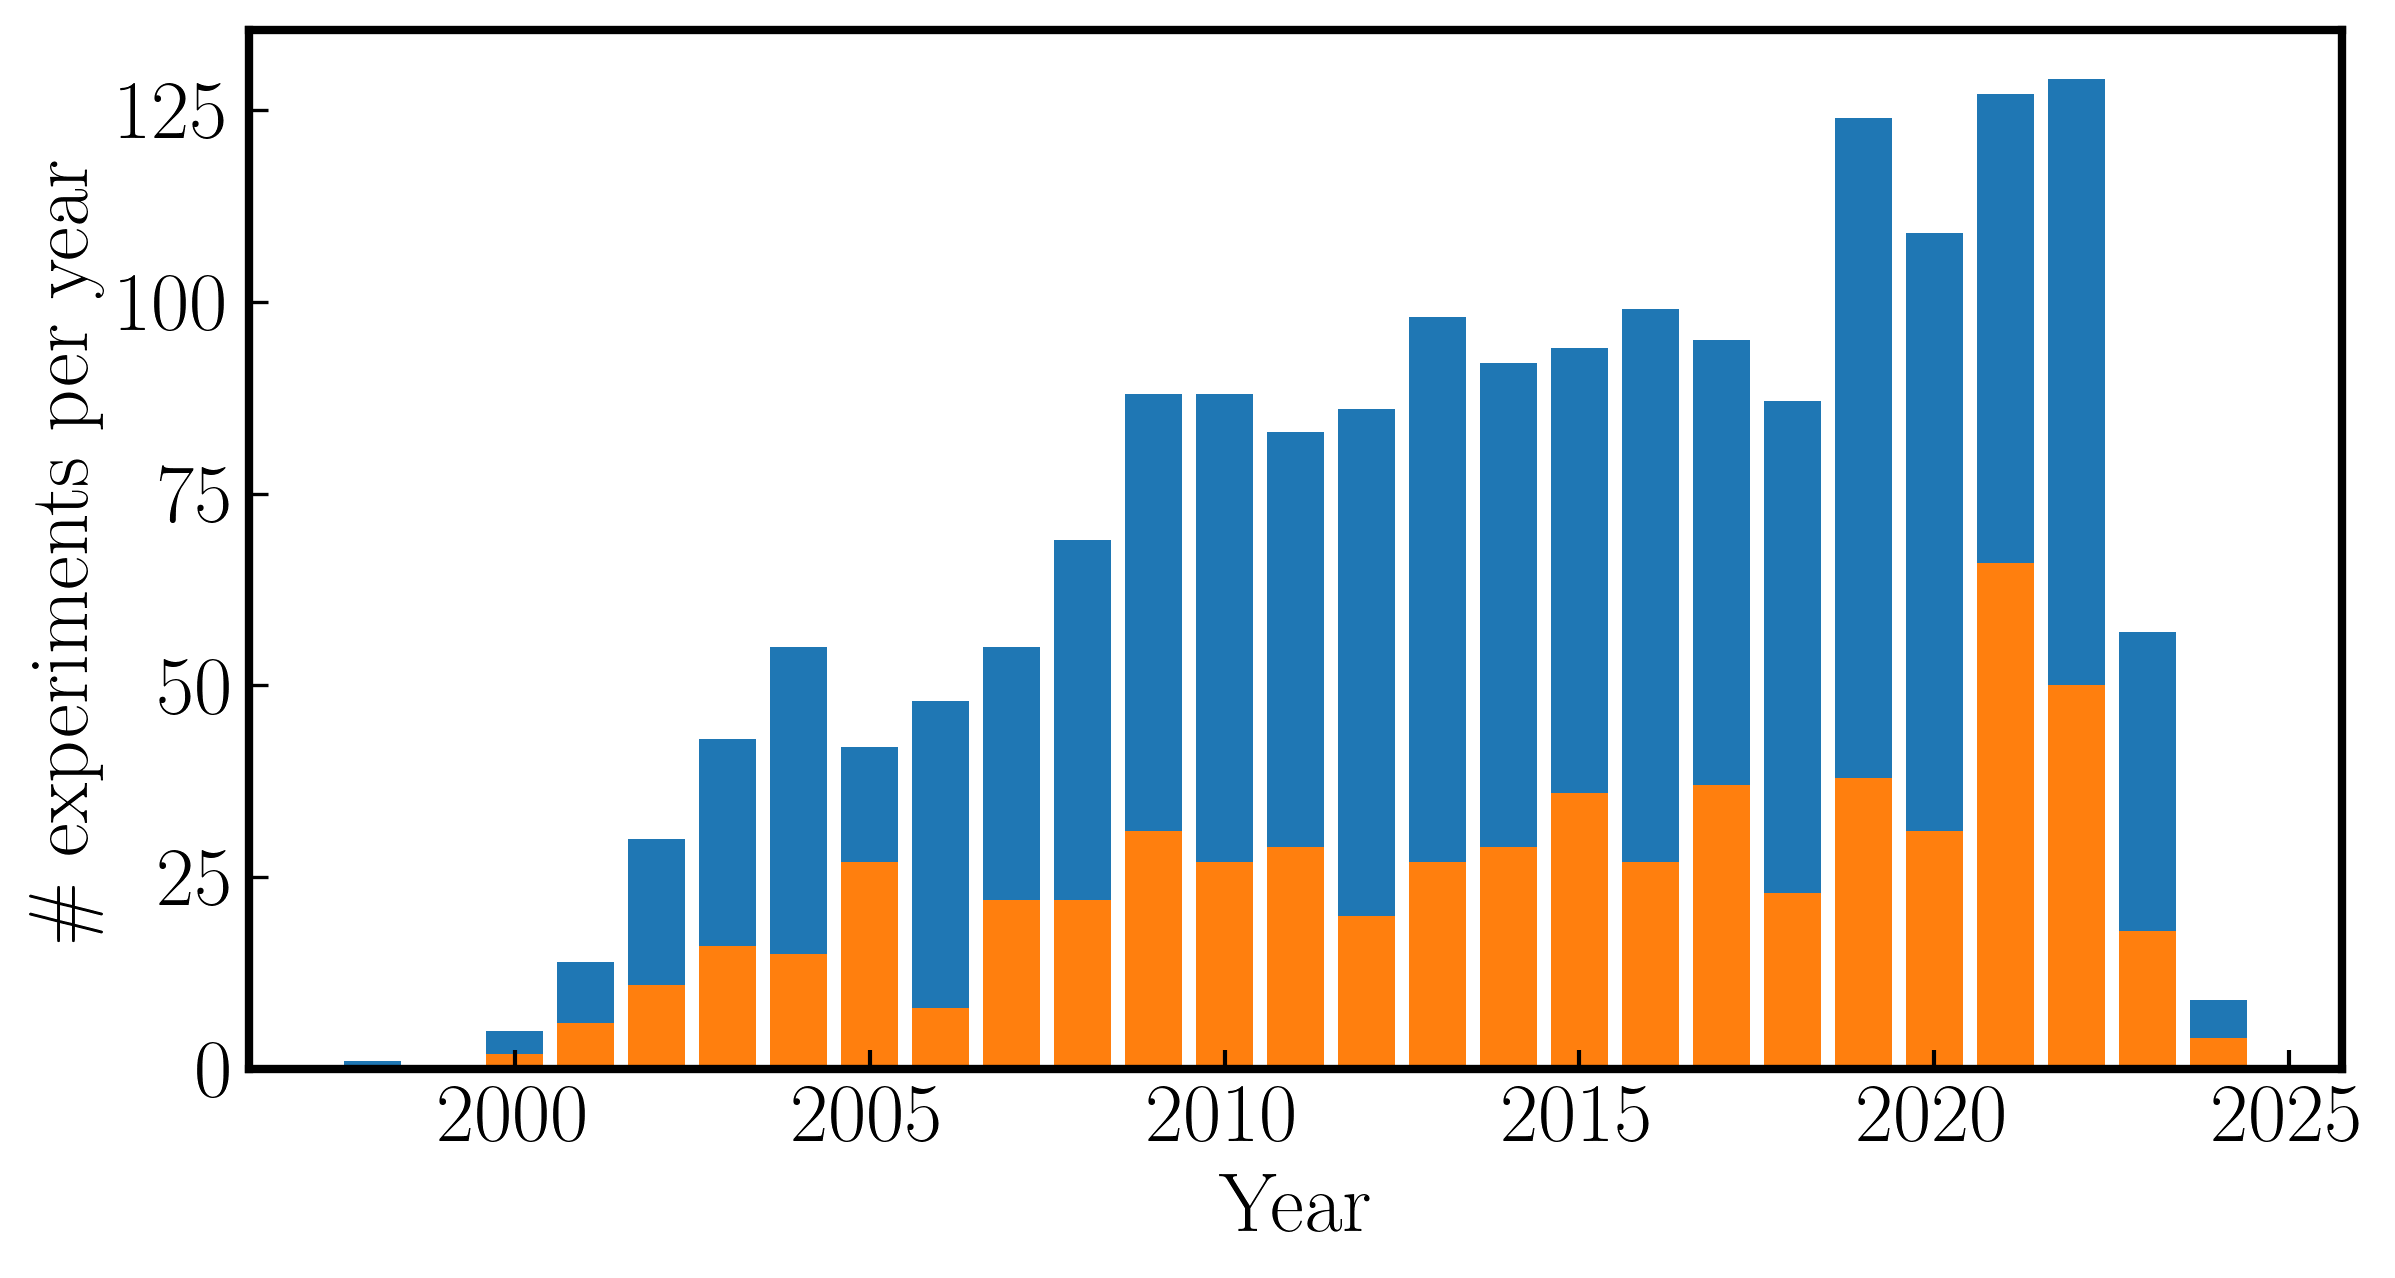

In [18]:
fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(111)
ax.bar(yr_iso[:-1],n_exp)
ax.bar(yr_iso[:-1],L_exp)
ax.set_xlabel('Year')
ax.set_ylabel('\# experiments per year')
plt.show()

### Use single year of data that is broadly representative of an EVN year

Take 2021

In [59]:
## sort out the unique times to remove the multi phase centre entries
yr_small = Time(['2021-01-01T00:00:00.000','2022-01-01T00:00:00.000']).mjd
at_21 = at[(at['t_min']>yr_small[0])&(at['t_min']<yr_small[1])]
at_temp, ar = np.unique(at_21['t_min','t_max'],return_index=True)
at_temp=at_21[ar]
at_temp_L = at_temp[(at_temp['em_min']>0.15)&(at_temp['em_max']<0.25)]
del ar, at_21

#### Some yearly stats for the paper

In [60]:
exp_names = np.unique(at_temp['obs_id'])
total_time = np.sum(at_temp['t_xel']*at_temp['t_resolution'])*u.s
total_time_L = np.sum(at_temp_L['t_xel']*at_temp_L['t_resolution'])*u.s

In [71]:
print('Total time in 2021')
total_time.to(u.day)

Total time in 2021


<Quantity 43.34206019 d>

In [72]:
print('Total time at L band (18/21 cm) in 2021')
total_time_L.to(u.day)

Total time at L band (18/21 cm) in 2021


<Quantity 25.09377315 d>

In [73]:
total_time_L/total_time

<Quantity 0.57897047>

#### Have some model for the sensitivity

The example array used will be an EVN+e-MERLIN array using the following - 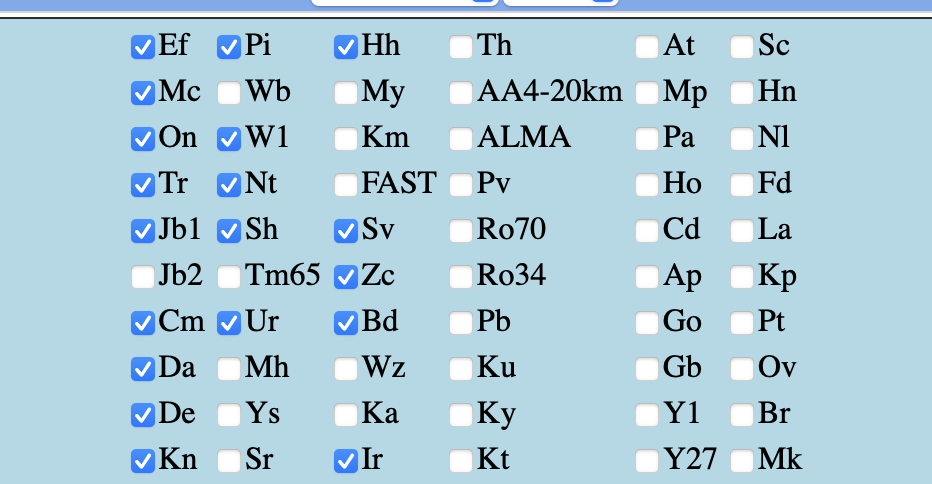

This gives a sensitivity of 11.86 uJy/beam for 100 mins / 6000 seconds at 1gbps data rate on source

Then, we can use the standard radiometer equation to set the model. Sensitivity will scale as the square root of the time on the source

t$$ \sigma~\mathrm{[\mu Jy\,beam^{-1}]} \approx 11.86\left(\frac{100}{t~\mathrm{[min]}}\right)^{1/2}$$

In [75]:
t_L = (at_temp_L['t_xel']*at_temp_L['t_resolution'])/60
at_temp_L['sens'] = 11.86*((100/t_L)**0.5)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/95/2mdwxkv53dg0z1fx0__lvyxw0000gq/T/ipykernel_9270/109952933.py:6: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('Estimated $1\sigma$ sensitivity ($\mathrm{\mu Jy\,beam^{-1}})$')


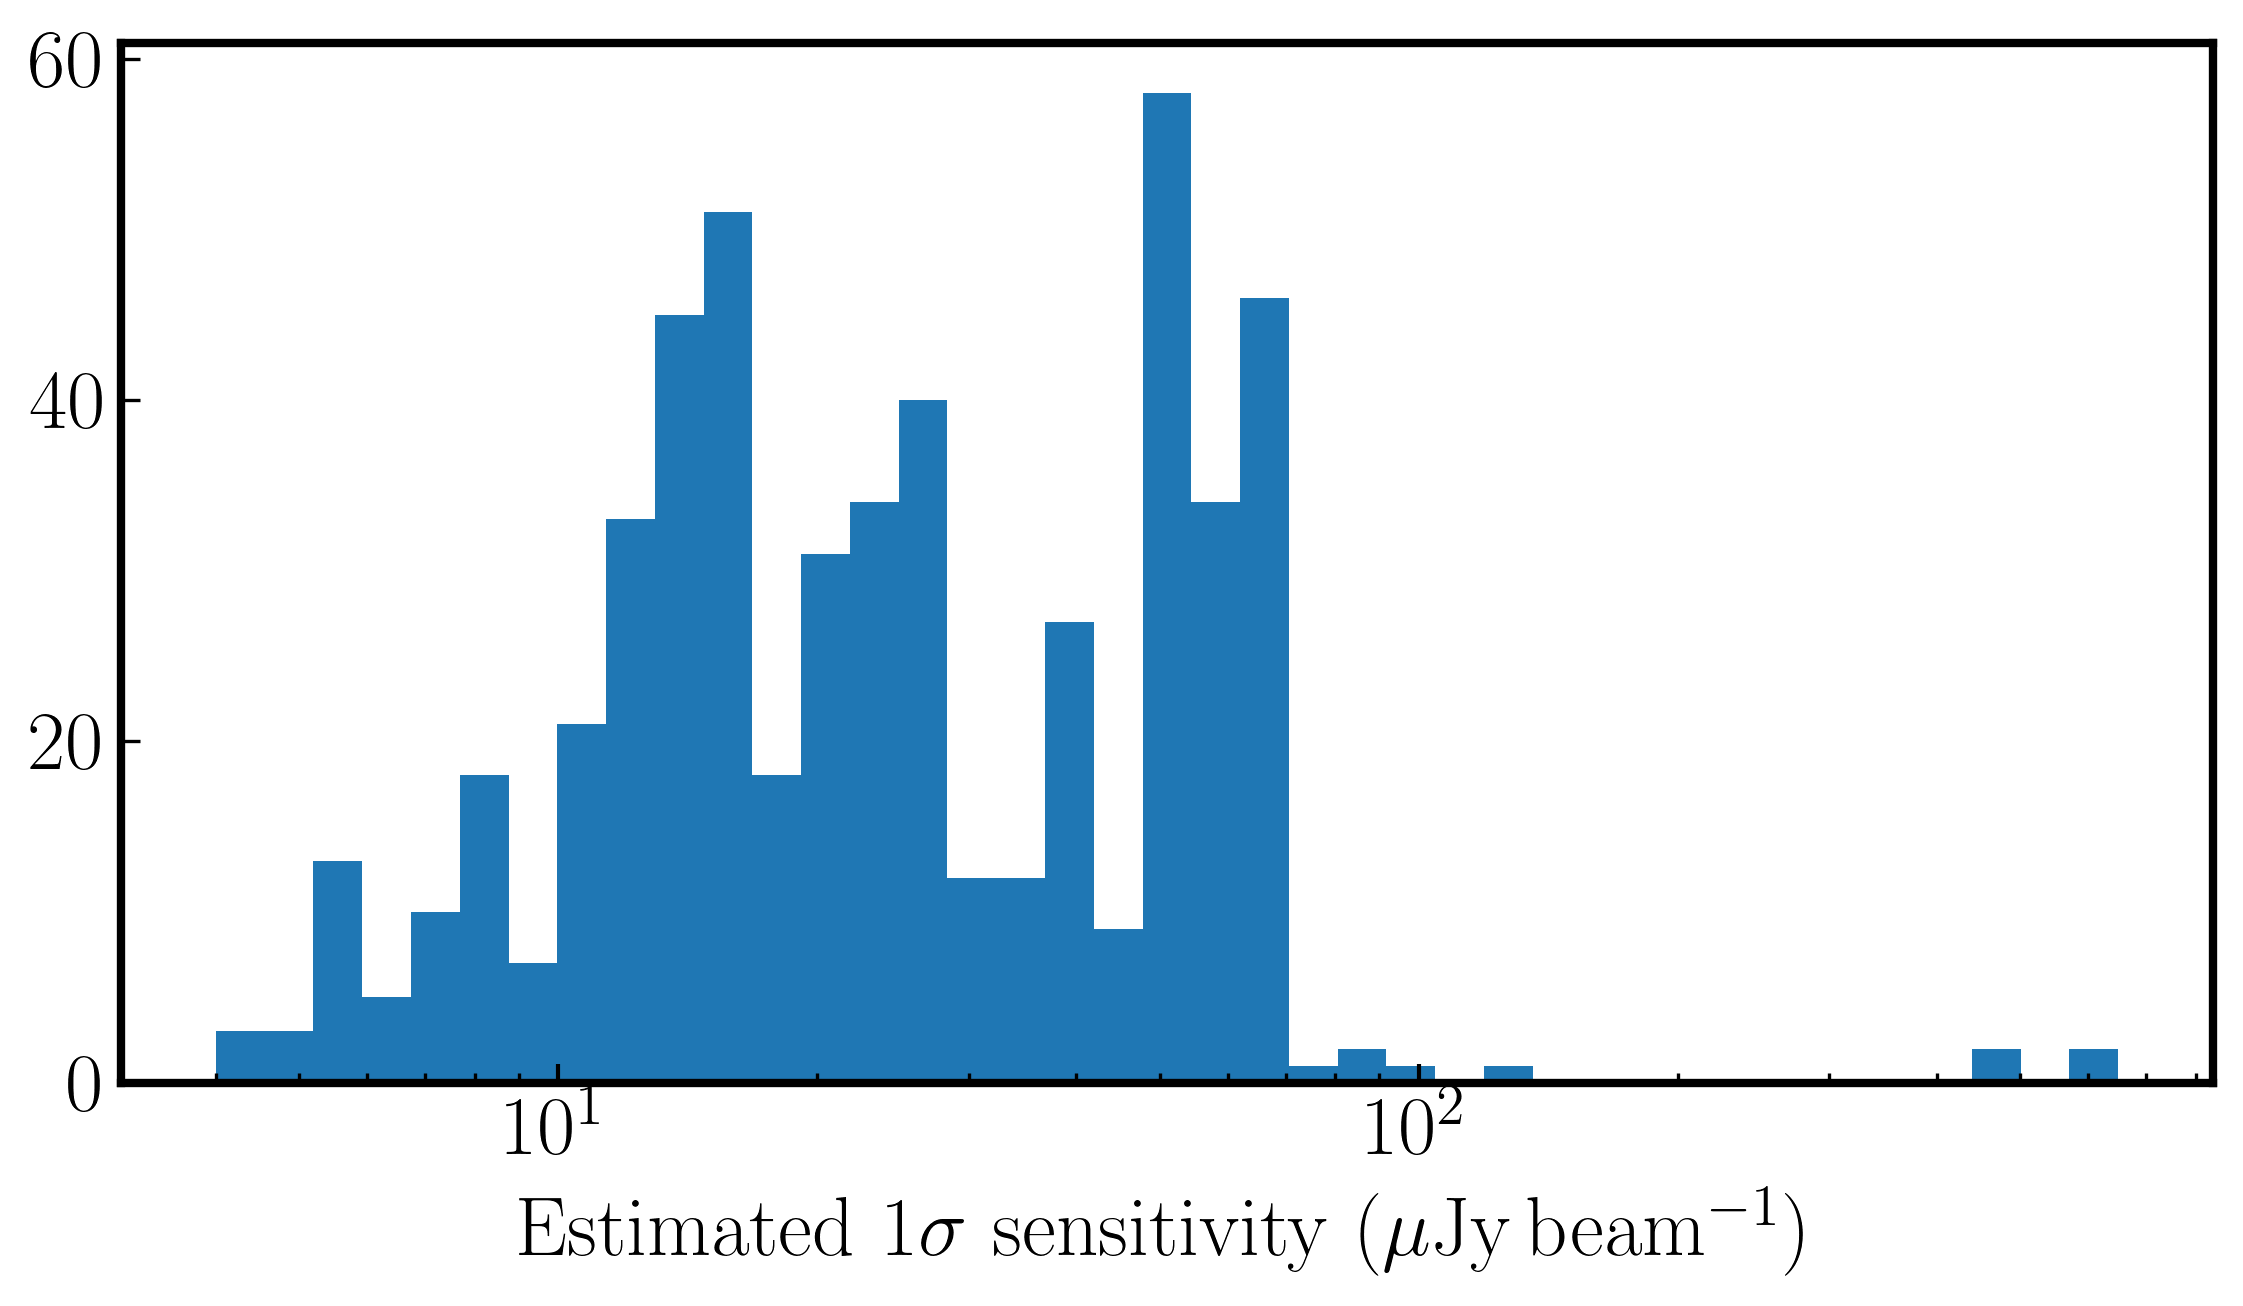

In [92]:
fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(111)
logbins = np.logspace(np.log10(np.min(at_temp_L['sens'])),np.log10(np.max(at_temp_L['sens'])),40)
ax.hist(at_temp_L['sens'],bins=logbins)
ax.set_xscale('log')
ax.set_xlabel('Estimated $1\sigma$ sensitivity ($\mathrm{\mu Jy\,beam^{-1}})$')
plt.show()

#### Areal density measurements